<a href="https://colab.research.google.com/github/20KMJ/ESAA7/blob/main/%EC%98%81%ED%99%94%EA%B4%80%EA%B0%9D%EC%88%98%EC%98%88%EC%B8%A1final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# 경로 이동
%cd /content/drive/MyDrive/ESAA/프로젝트/dataset/movies

Mounted at /content/drive
/content/drive/MyDrive/ESAA/프로젝트/dataset/movies


# 데이터 전처리 1

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")
sub_sample = pd.read_csv("submission.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


dir_prev_bfnum의 NaN 값을 어떻게 채울지 고민 필요함

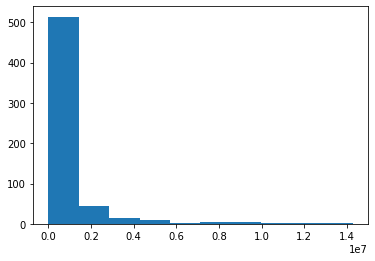

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train['box_off_num'])
plt.show()

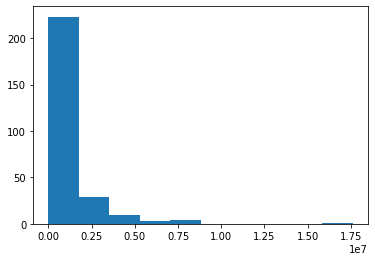

In [ ]:
# dir_prev_bfnum 분포
import matplotlib.pyplot as plt
plt.hist(train['dir_prev_bfnum'])
plt.show()

In [ ]:
print(train['dir_prev_bfnum'].sort_values()[:270].mean())
print(train['dir_prev_bfnum'].sort_values()[:270].quantile(0.25))
print(train['dir_prev_bfnum'].sort_values()[:270].median())

1050442.891419753
20380.0
478423.625


In [ ]:
# 영화 제목 칼럼 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)
# 감독명 칼럼 제거
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis= 1)
# Q1값으로 NaN값 채우기
train['dir_prev_bfnum'] = train['dir_prev_bfnum'].fillna(20380.0)
test['dir_prev_bfnum'] = test['dir_prev_bfnum'].fillna(20380.0)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   distributor     600 non-null    object 
 1   genre           600 non-null    object 
 2   release_time    600 non-null    object 
 3   time            600 non-null    int64  
 4   screening_rat   600 non-null    object 
 5   dir_prev_bfnum  600 non-null    float64
 6   dir_prev_num    600 non-null    int64  
 7   num_staff       600 non-null    int64  
 8   num_actor       600 non-null    int64  
 9   box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 47.0+ KB


In [ ]:
# 상위 5개의 배급사를 제외하고 '기타'로처리
distributor_list = train.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'

train['distributor'] = train['distributor'].apply(lambda x : func(x))
test['distributor'] = test['distributor'].apply(lambda x : func(x))

In [ ]:
# 개봉일을 바탕으로 년,월 변수 생성
train['년'] = train['release_time'].apply(lambda x: int(x[:4]))
train['월'] = train['release_time'].apply(lambda x: int(x[5:7]))
train =  train.drop(['release_time'],axis = 1)

test['년'] = test['release_time'].apply(lambda x: int(x[:4]))
test['월'] = test['release_time'].apply(lambda x: int(x[5:7]))
test =  test.drop(['release_time'],axis = 1)

In [ ]:
# 원핫 인코딩
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [ ]:
X = train.drop('box_off_num', axis=1)
y = train['box_off_num']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

## 모델 학습

In [ ]:
# LGBMRegressor
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_rmse = np.sqrt(lgbm_mse)
print(lgbm_rmse)

1322471.2048123626


In [ ]:
# Hyperparameter 튜닝
lgbm_params = {
    'n_estimators' : [80, 100, 120],
    'colsample_bytree' : [],
    'subsample' : []
}

from sklearn.model_selection import GridSearchCV
lgbm_grid_search = GridSearchCV(LGBMRegressor(), lgbm_params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
lgbm_grid_search.fit(X_train, y_train)
print(abs(lgbm_grid_search.best_score_))
print(grid_search.best_params_)

In [ ]:
lgbm_best = LGBMRegressor(**grid_search.best_params_)
lgbm_best.fit(X_train, y_train)
lgbm_best_pred = lgbm_best.predict(X_test)
lgbm_best_RMSE = mean_squared_error(y_test, lgbm_best_pred)**0.5
lgbm_best_RMSE

### **LinearRegression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [ ]:
# lr 모델 학습
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
print(lr_rmse)

1502492.6291135098


In [ ]:
# 교차검증
lr = LinearRegression()
neg_mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(avg_rmse)

1479815.5931412452


### **릿지 회귀**

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
alphas = [6, 6.2, 6.5, 6.7]
for alpha in alphas :
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_train, y_train)
  ridge_pred = ridge.predict(X_test)
  ridge_mse = mean_squared_error(y_test, ridge_pred)
  ridge_rmse = np.sqrt(ridge_mse)
  print(ridge_rmse)

1499226.0393157962
1499220.6966698347
1499218.3789821507
1499220.4172925858


In [ ]:
ridge = Ridge(alpha = 6.5)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(ridge_mse)
print(ridge_rmse)

1499218.3789821507


### **라쏘 회귀**

In [ ]:
alphas = [3430, 3435, 3440]
for alpha in alphas :
  lasso = Lasso(alpha = alpha)
  lasso.fit(X_train, y_train)
  lasso_pred = lasso.predict(X_test)
  lasso_mse = mean_squared_error(y_test, lasso_pred)
  lasso_rmse = np.sqrt(lasso_mse)
  print(lasso_rmse)

1499209.138265262
1499208.5485868836
1499209.0170697102


In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 3435)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_rmse = np.sqrt(lasso_mse)
print(lasso_rmse)

1499208.5485868836


# 데이터 전처리 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
train2 = pd.read_csv("movies_train.csv")
test2 = pd.read_csv("movies_test.csv")

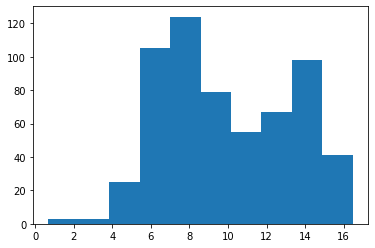

In [ ]:
train2['box_off_num'] = np.log1p(train2['box_off_num'])
plt.hist(train2['box_off_num'])
plt.show()

In [ ]:
# 영화 제목 칼럼 제거
train2 = train2.drop(['title'],axis= 1)
test2 = test2.drop(['title'],axis= 1)
# 감독명 칼럼 제거
train2 = train2.drop(['director'],axis = 1)
test2 = test2.drop(['director'],axis= 1)
# Q1값으로 NaN값 채우기
train2['dir_prev_bfnum'] = train2['dir_prev_bfnum'].fillna(20380.0)
test2['dir_prev_bfnum'] = test2['dir_prev_bfnum'].fillna(20380.0)
# 상위 5개의 배급사를 제외하고 '기타'로처리
distributor_list = train2.distributor.value_counts()[:5]
def func(distributor):
    if distributor in distributor_list:
        return distributor
    else:
        return '기타'
train2['distributor'] = train2['distributor'].apply(lambda x : func(x))
test2['distributor'] = test2['distributor'].apply(lambda x : func(x))
# 개봉일을 바탕으로 년,월 변수 생성
train2['년'] = train2['release_time'].apply(lambda x: int(x[:4]))
train2['월'] = train2['release_time'].apply(lambda x: int(x[5:7]))
train2 = train2.drop(['release_time'],axis = 1)
test2['년'] = test2['release_time'].apply(lambda x: int(x[:4]))
test2['월'] = test2['release_time'].apply(lambda x: int(x[5:7]))
test2 = test2.drop(['release_time'],axis = 1)
# 원핫 인코딩
train2 = pd.get_dummies(train2)
test2 = pd.get_dummies(test2)
# train/test split
X = train2.drop('box_off_num', axis=1)
y = train2['box_off_num']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

### **선형 회귀**

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
print(lr_rmse)

2.0923280590997653


In [ ]:
pred = lr.predict(test2)
submission = pd.read_csv("submission.csv")
submission['box_off_num']  = np.expm1(pred)
submission
submission['box_off_num'] = submission['box_off_num'].astype(int)

In [ ]:
submission.to_csv('베이스라인.csv',encoding='cp949',index=False)

# 데이터 전처리 3

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")

In [ ]:
# train, test 합치기
train['from'] = 'train'
test['from'] = 'test'
total = train.append(test)
total

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866.0,train
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,드라마,2015-11-19,78,15세 관람가,안슬기,2590.00,1,4,4,NaN,test
239,울보 권투부,인디스토리,다큐멘터리,2015-10-29,86,12세 관람가,이일하,NaN,0,18,2,NaN,test
240,어떤살인,(주)컨텐츠온미디어,느와르,2015-10-28,107,청소년 관람불가,안용훈,NaN,0,224,4,NaN,test
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,드라마,2015-10-22,102,청소년 관람불가,송동윤,50699.00,1,68,7,NaN,test


In [ ]:
# 개봉날짜 형변환 또는 연월 분리
total['year'] = total['release_time'].apply(lambda x: int(x[:4]))
total['month'] = total['release_time'].apply(lambda x: int(x[5:7]))
total =  total.drop(['release_time'],axis = 1)
total.head(3)

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month
0,개들의 전쟁,롯데엔터테인먼트,액션,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train,2012,11
1,내부자들,(주)쇼박스,느와르,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train,2015,11
2,은밀하게 위대하게,(주)쇼박스,액션,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train,2013,6


In [ ]:
# 장르 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(total.genre)
total.genre = encoder.transform(total.genre)
total.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month
0,개들의 전쟁,롯데엔터테인먼트,10,96,청소년 관람불가,조병옥,NaN,0,91,2,23398.0,train,2012,11
1,내부자들,(주)쇼박스,2,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501.0,train,2015,11
2,은밀하게 위대하게,(주)쇼박스,10,123,15세 관람가,장철수,220775.25,4,343,4,6959083.0,train,2013,6
3,나는 공무원이다,(주)NEW,11,101,전체 관람가,구자홍,23894.00,2,20,6,217866.0,train,2012,7
4,불량남녀,쇼박스(주)미디어플렉스,11,108,15세 관람가,신근호,1.00,1,251,2,483387.0,train,2010,11


In [ ]:
# 관람등급 라벨 인코딩
rat_encoder = LabelEncoder()
rat_encoder.fit(total.screening_rat)
total.screening_rat = rat_encoder.transform(total.screening_rat)
total.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month
0,개들의 전쟁,롯데엔터테인먼트,10,96,3,조병옥,NaN,0,91,2,23398.0,train,2012,11
1,내부자들,(주)쇼박스,2,130,3,우민호,1161602.50,2,387,3,7072501.0,train,2015,11
2,은밀하게 위대하게,(주)쇼박스,10,123,1,장철수,220775.25,4,343,4,6959083.0,train,2013,6
3,나는 공무원이다,(주)NEW,11,101,2,구자홍,23894.00,2,20,6,217866.0,train,2012,7
4,불량남녀,쇼박스(주)미디어플렉스,11,108,1,신근호,1.00,1,251,2,483387.0,train,2010,11


In [ ]:
# 상위 6개의 배급사를 제외하고 기타로 처리
distributor_list = total.distributor.value_counts()[:6]
def func(distributor):
  if distributor in distributor_list:
    return distributor
  else:
    return '기타'

total['distributor'] = total['distributor'].apply(lambda x : func(x))

In [ ]:
# 배급사 라벨 인코딩
dis_encoder = LabelEncoder()
dis_encoder.fit(total['distributor'])
total['distributor'] = dis_encoder.transform(total['distributor'])
total.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month
0,개들의 전쟁,5,10,96,3,조병옥,NaN,0,91,2,23398.0,train,2012,11
1,내부자들,2,2,130,3,우민호,1161602.50,2,387,3,7072501.0,train,2015,11
2,은밀하게 위대하게,2,10,123,1,장철수,220775.25,4,343,4,6959083.0,train,2013,6
3,나는 공무원이다,0,11,101,2,구자홍,23894.00,2,20,6,217866.0,train,2012,7
4,불량남녀,4,11,108,1,신근호,1.00,1,251,2,483387.0,train,2010,11


In [ ]:
dir = total[:600].groupby('director', as_index=False)[['director','box_off_num']].mean().sort_values(by='box_off_num',ascending=False)
dir

,director,box_off_num
264,윤제균,14262766.0
416,최동훈,12845252.0
241,양우석,11374879.0
201,봉준호,9350351.0
448,한재림,9135806.0
...,...,...
411,진광교,36.0
289,이세일,10.0
10,고구마,8.0
85,김정호,2.0


In [ ]:
# 감독 그룹화
top10_list = dir['director'][:10].to_list()
top20_list = dir['director'][10:20].to_list()
top50_list = dir['director'][20:50].to_list()
top100_list = dir['director'][50:100].to_list()
top200_list = dir['director'][100:200].to_list()
bottom_list = dir['director'][200:].to_list()
def func(director):
  if director in top10_list:
    return 'top10_list'
  elif director in top20_list:
    return 'top20_list'
  elif director in top50_list:
    return 'top50_list'
  elif director in top100_list:
    return 'top100_list'
  elif director in top200_list:
    return 'top200_list'
  else:
    return 'bottom_list'
total['director'] = total['director'].apply(lambda x : func(x))
total['director'].unique()

array(['bottom_list', 'top50_list', 'top10_list', 'top200_list',
       'top100_list', 'top20_list'], dtype=object)

In [ ]:
# 감독 라벨 인코딩
dir_encoder = LabelEncoder()
dir_encoder.fit(total['director'])
total['director'] = dir_encoder.transform(total['director'])
total.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month
0,개들의 전쟁,5,10,96,3,0,NaN,0,91,2,23398.0,train,2012,11
1,내부자들,2,2,130,3,5,1161602.50,2,387,3,7072501.0,train,2015,11
2,은밀하게 위대하게,2,10,123,1,2,220775.25,4,343,4,6959083.0,train,2013,6
3,나는 공무원이다,0,11,101,2,3,23894.00,2,20,6,217866.0,train,2012,7
4,불량남녀,4,11,108,1,3,1.00,1,251,2,483387.0,train,2010,11


In [ ]:
# dir_prev_bfnum, title 칼럼 drop
total.drop(columns=['dir_prev_bfnum', 'title'], inplace=True)
total.head(3)

,distributor,genre,time,screening_rat,director,dir_prev_num,num_staff,num_actor,box_off_num,from,year,month
0,5,10,96,3,0,0,91,2,23398.0,train,2012,11
1,2,2,130,3,5,2,387,3,7072501.0,train,2015,11
2,2,10,123,1,2,4,343,4,6959083.0,train,2013,6


In [ ]:
total = total.drop('from', axis=1)

In [ ]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843 entries, 0 to 242
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distributor    843 non-null    int64  
 1   genre          843 non-null    int64  
 2   time           843 non-null    int64  
 3   screening_rat  843 non-null    int64  
 4   director       843 non-null    int64  
 5   dir_prev_num   843 non-null    int64  
 6   num_staff      843 non-null    int64  
 7   num_actor      843 non-null    int64  
 8   box_off_num    600 non-null    float64
 9   year           843 non-null    int64  
 10  month          843 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 79.0 KB


In [ ]:
train = total[:600]
test = total[600:]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   distributor    600 non-null    int64  
 1   genre          600 non-null    int64  
 2   time           600 non-null    int64  
 3   screening_rat  600 non-null    int64  
 4   director       600 non-null    int64  
 5   dir_prev_num   600 non-null    int64  
 6   num_staff      600 non-null    int64  
 7   num_actor      600 non-null    int64  
 8   box_off_num    600 non-null    float64
 9   year           600 non-null    int64  
 10  month          600 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 56.2 KB


In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

X = train.drop('box_off_num', axis=1)
y = train['box_off_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
# 선형 회귀
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

np.sqrt(mean_squared_error(y_test,lr_pred))

1523104.7525825799

In [ ]:
# LGBMRegressor
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(random_state=0)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

np.sqrt(mean_squared_error(y_test,lgbm_pred))

915376.4349642855

In [ ]:
# XGBRegressor
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=0)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

np.sqrt(mean_squared_error(y_test,xgb_pred))

[09:35:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


860446.7108542774

In [ ]:
submission = pd.read_csv("submission.csv")

In [ ]:
test_x = test.drop('box_off_num', axis=1)
pred = xgb.predict(test_x)
test_x = pd.DataFrame(pred)
submission['box_off_num'] = test_x

In [ ]:
submission

,title,box_off_num
0,용서는 없다,8.540664e+05
1,아빠가 여자를 좋아해,7.514272e+05
2,하모니,7.794616e+05
3,의형제,2.457100e+06
4,평행 이론,6.132144e+05
...,...,...
238,해에게서 소년에게,-2.277582e+04
239,울보 권투부,-2.277582e+04
240,어떤살인,9.643452e+04
241,말하지 못한 비밀,-2.277582e+04


In [ ]:
submission.to_csv('xgb.csv', encoding = 'utf-8-sig', index=False)

리더보드 점수: 1261428.47477

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth':[5,6,7],
          'min_child_weight':[0.3, 0.5, 0.7, 1],
          'subsample':[0.7, 0.8, 0.9],
          'gamma':[0,0.05,0.1]
}

grid_clf = GridSearchCV(xgb, param_grid=params, scoring='neg_mean_squared_error', cv=3)
grid_clf.fit(X_train, y_train)
print('최적의 하이퍼 파라미터 : {0}, 최적 평균 Negative MSE scores : {1:.3f}'.format(grid_clf.best_params_,
                                                     np.sqrt(-1 * grid_clf.best_score_)))

[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# XGBRegressor (리더보드: 1199122.5544090564)
from xgboost import XGBRegressor

xgb_final = XGBRegressor(gamma=0, max_depth=6, min_child_weight=0.5, subsample=0.8 ,random_state=0)
xgb_final.fit(X_train, y_train)
xgb_final_pred = xgb_final.predict(X_test)

np.sqrt(mean_squared_error(y_test,xgb_final_pred))

[10:24:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


863238.5456175079

In [ ]:
# XGBRegressor (리더보드: 1203955.4412657241)
from xgboost import XGBRegressor

xgb_final2 = XGBRegressor(gamma=0, max_depth=5, min_child_weight=0.3, subsample=0.8 ,random_state=0)
xgb_final2.fit(X_train, y_train)
xgb_final2_pred = xgb_final2.predict(X_test)

np.sqrt(mean_squared_error(y_test,xgb_final2_pred))

[10:38:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


840413.4947288844

In [ ]:
test_x = test.drop('box_off_num', axis=1)
pred = xgb_final2.predict(test_x)
test_x = pd.DataFrame(pred)
submission['box_off_num'] = test_x
submission.to_csv('xgb_final2.csv', encoding = 'utf-8-sig', index=False)

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")
# train, test 합치기
train['from'] = 'train'
test['from'] = 'test'
total = train.append(test)
# 개봉날짜 형변환 또는 연월 분리
total['year'] = total['release_time'].apply(lambda x: int(x[:4]))
total['month'] = total['release_time'].apply(lambda x: int(x[5:7]))
total =  total.drop(['release_time'],axis = 1)
# 장르 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(total.genre)
total.genre = encoder.transform(total.genre)
# 관람 등급 라벨 인코딩
rat_encoder = LabelEncoder()
rat_encoder.fit(total.screening_rat)
total.screening_rat = rat_encoder.transform(total.screening_rat)
# 배급사 전처리
total['distributor'] = total['distributor'].replace(['CJ 엔터테인먼트', 'CJ E&M Pictures', 'CJ E&M 영화부문', 'CJ CGV', 'CGV 아트하우스', 'CGV아트하우스', 'CGV 무비꼴라쥬'], ['CJ']*7)
total['distributor'] = total['distributor'].replace(['마운틴 픽처스', '더픽쳐스/(주)마운틴픽쳐스', '(주)마운틴픽쳐스', '마운틴픽쳐스', '(주)씨타마운틴픽쳐스'], ['마운틴픽쳐스']*5)
total['distributor'] = total['distributor'].replace(['(주)쇼박스', '쇼박스(주)미디어플렉스' ], ['쇼박스']*2)
total['distributor'] = total['distributor'].replace(['(주)NEW', 'NEW' ], ['NEW']*2)
total['distributor'] = total['distributor'].replace(['KT&G 상상마당', 'KT' ], ['KT']*2)
total['distributor'] = total['distributor'].replace(['롯데엔터테인먼트', '롯데쇼핑(주)롯데엔터테인먼트' ], ['롯데']*2)
total['distributor'] = total['distributor'].replace(['싸이더스FNH', '싸이더스', '싸이더스 FNH'], ['싸이더스']*3)
total['distributor'] = total['distributor'].replace(['(주)리틀빅픽처스', '리틀빅픽처스', '리틀빅픽쳐스' ], ['리틀빅픽쳐스']*3)
total['distributor'] = total['distributor'].replace(['(주)마인스엔터테인먼트', '(주)마인스 엔터테인먼트' ], ['마인스엔터테인먼트']*2)
total['distributor'] = total['distributor'].replace(['SK플래닛', 'SK텔레콤(주)' ], ['SK']*2)
total['distributor'] = total['distributor'].replace(['(주)시네마달', '시네마 달', '시네마달' ], ['시네마달']*3)
total['distributor'] = total['distributor'].replace(['THE 픽쳐스', '(주)더픽쳐스' ], ['더픽쳐스']*2)
total['distributor'] = total['distributor'].replace(['메가박스중앙(주)플러스엠', '메가박스(주)플러스엠' ], ['메가박스']*2)
total['distributor'] = total['distributor'].replace(['(주)디씨드', '디씨드', '디 씨드' ], ['디씨드']*3)
# 상위 6개의 배급사를 제외하고 기타로 처리
distributor_list = total.distributor.value_counts()[:6]
def func(distributor):
  if distributor in distributor_list:
    return distributor
  else:
    return '기타'
total['distributor'] = total['distributor'].apply(lambda x : func(x))
# 배급사 라벨 인코딩
dis_encoder = LabelEncoder()
dis_encoder.fit(total['distributor'])
total['distributor'] = dis_encoder.transform(total['distributor'])
# 감독 그룹화
top10_list = dir['director'][:10].to_list()
top20_list = dir['director'][10:20].to_list()
top50_list = dir['director'][20:50].to_list()
top100_list = dir['director'][50:100].to_list()
top200_list = dir['director'][100:200].to_list()
bottom_list = dir['director'][200:].to_list()
def func(director):
  if director in top10_list:
    return 'top10_list'
  elif director in top20_list:
    return 'top20_list'
  elif director in top50_list:
    return 'top50_list'
  elif director in top100_list:
    return 'top100_list'
  elif director in top200_list:
    return 'top200_list'
  else:
    return 'bottom_list'
total['director'] = total['director'].apply(lambda x : func(x))
# 감독 라벨 인코딩
dir_encoder = LabelEncoder()
dir_encoder.fit(total['director'])
total['director'] = dir_encoder.transform(total['director'])
# dir_prev_bfnum, title 칼럼 drop
total.drop(columns=['dir_prev_bfnum', 'title'], inplace=True)
total = total.drop('from', axis=1)
train = total[:600]
test = total[600:]

In [ ]:
# XGBRegressor
from xgboost import XGBRegressor

xgb3 = XGBRegressor(gamma=0, max_depth=6, min_child_weight=0.5, subsample=0.8, random_state=0)
xgb3.fit(X_train, y_train)
xgb3_pred = xgb3.predict(X_test)

np.sqrt(mean_squared_error(y_test,xgb3_pred))

[10:52:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


863238.5456175079

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth':[5,6,7],
          'min_child_weight':[0.3, 0.5, 0.7, 1],
          'subsample':[0.7, 0.8, 0.9],
          'gamma':[0,0.05,0.1]
}

grid_clf = GridSearchCV(xgb, param_grid=params, scoring='neg_mean_squared_error', cv=3)
grid_clf.fit(X_train, y_train)
print('최적의 하이퍼 파라미터 : {0}, 최적 평균 Negative MSE scores : {1:.3f}'.format(grid_clf.best_params_,
                                                     np.sqrt(-1 * grid_clf.best_score_)))

In [ ]:
test_x = test.drop('box_off_num', axis=1)
pred = xgb.predict(test_x)
test_x = pd.DataFrame(pred)
submission['box_off_num'] = test_x

submission.to_csv('xgb3.csv', encoding = 'utf-8-sig', index=False)

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")
# train, test 합치기
train['from'] = 'train'
test['from'] = 'test'
total = train.append(test)
# 개봉날짜 형변환 또는 연월 분리
total['year'] = total['release_time'].apply(lambda x: int(x[:4]))
total['month'] = total['release_time'].apply(lambda x: int(x[5:7]))
total =  total.drop(['release_time'],axis = 1)
# 장르 라벨 인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(total.genre)
total.genre = encoder.transform(total.genre)
# 관람 등급 라벨 인코딩
rat_encoder = LabelEncoder()
rat_encoder.fit(total.screening_rat)
total.screening_rat = rat_encoder.transform(total.screening_rat)
dist = total[:600].groupby('distributor', as_index=False)[['distributor','box_off_num']].mean().sort_values(by='box_off_num',ascending=False)
dist
# 배급사 그룹화
top10_list = dist['distributor'][:10].to_list()
top20_list = dist['distributor'][10:20].to_list()
top50_list = dist['distributor'][20:50].to_list()
top100_list = dist['distributor'][50:100].to_list()
top200_list = dist['distributor'][100:].to_list()
def func(distributor):
  if distributor in top10_list:
    return 'top10_list'
  elif distributor in top20_list:
    return 'top20_list'
  elif distributor in top50_list:
    return 'top50_list'
  elif distributor in top100_list:
    return 'top100_list'
  else:
    return 'bottom_list'
total['distributor'] = total['distributor'].apply(lambda x : func(x))
total['distributor'].unique()
# 배급사 라벨 인코딩
dis_encoder = LabelEncoder()
dis_encoder.fit(total['distributor'])
total['distributor'] = dis_encoder.transform(total['distributor'])
# 감독 그룹화
top10_list = dir['director'][:10].to_list()
top20_list = dir['director'][10:20].to_list()
top50_list = dir['director'][20:50].to_list()
top100_list = dir['director'][50:100].to_list()
top200_list = dir['director'][100:200].to_list()
bottom_list = dir['director'][200:].to_list()
def func(director):
  if director in top10_list:
    return 'top10_list'
  elif director in top20_list:
    return 'top20_list'
  elif director in top50_list:
    return 'top50_list'
  elif director in top100_list:
    return 'top100_list'
  elif director in top200_list:
    return 'top200_list'
  else:
    return 'bottom_list'
total['director'] = total['director'].apply(lambda x : func(x))
# 감독 라벨 인코딩
dir_encoder = LabelEncoder()
dir_encoder.fit(total['director'])
total['director'] = dir_encoder.transform(total['director'])
# dir_prev_bfnum, title 칼럼 drop
total.drop(columns=['dir_prev_bfnum', 'title'], inplace=True)
total = total.drop('from', axis=1)
train = total[:600]
test = total[600:]

In [ ]:
# XGBRegressor (리더보드: 1195914.1624242547)
from xgboost import XGBRegressor

xgb4 = XGBRegressor(gamma=0, max_depth=6, min_child_weight=0.5, subsample=0.8 ,random_state=0)
xgb4.fit(X_train, y_train)
xgb4_pred = xgb_final.predict(X_test)

np.sqrt(mean_squared_error(y_test,xgb4_pred))

[10:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


863238.5456175079

In [ ]:
test_x = test.drop('box_off_num', axis=1)
pred = xgb.predict(test_x)
test_x = pd.DataFrame(pred)
submission['box_off_num'] = test_x

submission.to_csv('xgb4.csv', encoding = 'utf-8-sig', index=False)

In [ ]:
train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")
# train, test 합치기
train['from'] = 'train'
test['from'] = 'test'
total = train.append(test)
# 개봉날짜 형변환 또는 연월 분리
total['year'] = total['release_time'].apply(lambda x: int(x[:4]))
total['month'] = total['release_time'].apply(lambda x: int(x[5:7]))
total =  total.drop(['release_time'],axis = 1)
total['genre'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
# 관람 등급 라벨 인코딩
rat_encoder = LabelEncoder()
rat_encoder.fit(total.screening_rat)
total.screening_rat = rat_encoder.transform(total.screening_rat)
dist = total[:600].groupby('distributor', as_index=False)[['distributor','box_off_num']].mean().sort_values(by='box_off_num',ascending=False)
dist
# 배급사 그룹화
top10_list = dist['distributor'][:10].to_list()
top20_list = dist['distributor'][10:20].to_list()
top50_list = dist['distributor'][20:50].to_list()
top100_list = dist['distributor'][50:100].to_list()
top200_list = dist['distributor'][100:].to_list()
def func(distributor):
  if distributor in top10_list:
    return 'top10_list'
  elif distributor in top20_list:
    return 'top20_list'
  elif distributor in top50_list:
    return 'top50_list'
  elif distributor in top100_list:
    return 'top100_list'
  else:
    return 'bottom_list'
total['distributor'] = total['distributor'].apply(lambda x : func(x))
total['distributor'].unique()
# 배급사 라벨 인코딩
dis_encoder = LabelEncoder()
dis_encoder.fit(total['distributor'])
total['distributor'] = dis_encoder.transform(total['distributor'])
# 감독 그룹화
top10_list = dir['director'][:10].to_list()
top20_list = dir['director'][10:20].to_list()
top50_list = dir['director'][20:50].to_list()
top100_list = dir['director'][50:100].to_list()
top200_list = dir['director'][100:200].to_list()
bottom_list = dir['director'][200:].to_list()
def func(director):
  if director in top10_list:
    return 'top10_list'
  elif director in top20_list:
    return 'top20_list'
  elif director in top50_list:
    return 'top50_list'
  elif director in top100_list:
    return 'top100_list'
  elif director in top200_list:
    return 'top200_list'
  else:
    return 'bottom_list'
total['director'] = total['director'].apply(lambda x : func(x))
# 감독 라벨 인코딩
dir_encoder = LabelEncoder()
dir_encoder.fit(total['director'])
total['director'] = dir_encoder.transform(total['director'])
# dir_prev_bfnum, title 칼럼 drop
total.drop(columns=['dir_prev_bfnum', 'title'], inplace=True)
total = total.drop('from', axis=1)
train = total[:600]
test = total[600:]
X = train.drop('box_off_num', axis=1)
y = train['box_off_num']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
xgb5 = XGBRegressor(random_state=0)
xgb5.fit(X_train, y_train)
xgb5_pred = xgb5.predict(X_test)

np.sqrt(mean_squared_error(y_test,xgb5_pred))

[11:22:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


832128.5895141849

In [ ]:
test_x = test.drop('box_off_num', axis=1)
pred = xgb5.predict(test_x)
test_x = pd.DataFrame(pred)
submission['box_off_num'] = test_x

submission.to_csv('xgb5.csv', encoding = 'utf-8-sig', index=False)

In [ ]:
xgb6 = XGBRegressor(gamma=0, max_depth=6, min_child_weight=0.5, subsample=0.8 ,random_state=0)
xgb6.fit(X_train, y_train)
xgb6_pred = xgb6.predict(X_test)

np.sqrt(mean_squared_error(y_test,xgb6_pred))

[11:24:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


801074.8098638393

In [ ]:
test_x = test.drop('box_off_num', axis=1)
pred = xgb6.predict(test_x)
test_x = pd.DataFrame(pred)
submission['box_off_num'] = test_x

submission.to_csv('xgb6.csv', encoding = 'utf-8-sig', index=False)